##### import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import models

In [2]:
CATEGORIES = ['Black-grass',
          'Charlock',
          'Cleavers',
          'Common Chickweed',
          'Common wheat',
          'Fat Hen',
          'Loose Silky-bent',
          'Maize',
          'Scentless Mayweed',
          'Shepherds Purse',
          'Small-flowered Cranesbill',
          'Sugar beet']

IMG_SIZE=224

DATADIR  = 'D:/project/dataset/train'
DATADIR_TEST  = 'D:/project/dataset/test'

In [3]:
TRAIN_DATA_DIR = DATADIR
batch_size = 16
# create data generators
def data_generators():

    # apply random transformations on training data
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = 0.1,
    )
    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255)
    
    train_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        target_size = (IMG_SIZE, IMG_SIZE),
        color_mode = 'rgb',
        class_mode = "categorical",
        batch_size = batch_size,
        subset = 'training',
    )

    # define validation data generator
    validation_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        color_mode = 'rgb',
        class_mode = "categorical",
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        subset = 'validation',
        shuffle=False
    )
    test_gen = test_data_generator.flow_from_directory(
        directory= 'D:/project/dataset',
        classes=['test'],
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')
    return train_gen, validation_gen, test_gen
train_gen, validation_gen, test_gen = data_generators()

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


In [4]:
print(train_gen.class_indices)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [5]:
#create Sequential
model = models.Sequential()


model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1)) #dropout for each layer in order to avoid overfitting.


model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))



model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [7]:
optimizer = keras.optimizers.Adam(0.0005)

In [8]:
model.compile(optimizer= optimizer ,loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# save best model regularly
save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'best.h5',monitor = 'val_accuracy', 
                                                     save_best_only = True, verbose = 1,mode='max')
# reduce learning rate when it stops decreasing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4,patience = 3,
                                                 min_lr = 1e-10, verbose = 1, cooldown = 1)
# stop training early if no further improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-2, patience = 10, verbose = 1,
        mode = 'max', baseline = None, restore_best_weights = True)
callback=[save_best_model, reduce_lr, early_stopping]

In [10]:
history = model.fit(train_gen,
          epochs = 100,
          steps_per_epoch=train_gen.samples // batch_size,
          validation_data = validation_gen,
          validation_steps = validation_gen.samples // batch_size,
          callbacks=callback)

Epoch 1/100
267/267 [==============================] - ETA: 0s - loss: 2.3177 - accuracy: 0.1830
Epoch 1: val_accuracy improved from -inf to 0.30388, saving model to best.h5
267/267 [==============================] - 480s 2s/step - loss: 2.3177 - accuracy: 0.1830 - val_loss: 2.0257 - val_accuracy: 0.3039 - lr: 5.0000e-04
Epoch 2/100
267/267 [==============================] - ETA: 0s - loss: 1.7917 - accuracy: 0.3547
Epoch 2: val_accuracy improved from 0.30388 to 0.37069, saving model to best.h5
267/267 [==============================] - 422s 2s/step - loss: 1.7917 - accuracy: 0.3547 - val_loss: 1.7727 - val_accuracy: 0.3707 - lr: 5.0000e-04
Epoch 3/100
267/267 [==============================] - ETA: 0s - loss: 1.5098 - accuracy: 0.4598
Epoch 3: val_accuracy improved from 0.37069 to 0.51509, saving model to best.h5
267/267 [==============================] - 423s 2s/step - loss: 1.5098 - accuracy: 0.4598 - val_loss: 1.3930 - val_accuracy: 0.5151 - lr: 5.0000e-04
Epoch 4/100
267/267 [====

Epoch 27/100
267/267 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8487
Epoch 27: val_accuracy did not improve from 0.86638

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
267/267 [==============================] - 418s 2s/step - loss: 0.3979 - accuracy: 0.8487 - val_loss: 0.4240 - val_accuracy: 0.8470 - lr: 5.0000e-04
Epoch 28/100
267/267 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8853
Epoch 28: val_accuracy improved from 0.86638 to 0.87931, saving model to best.h5
267/267 [==============================] - 424s 2s/step - loss: 0.3094 - accuracy: 0.8853 - val_loss: 0.3685 - val_accuracy: 0.8793 - lr: 2.0000e-04
Epoch 29/100
267/267 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8958
Epoch 29: val_accuracy improved from 0.87931 to 0.88578, saving model to best.h5
267/267 [==============================] - 387s 1s/step - loss: 0.2904 - accuracy: 0.8958 - val_loss: 0.3762 - val_

In [11]:
model = models.load_model('best.h5')

In [12]:
model.evaluate(test_gen)

794/794 [==============================] - 13s 17ms/step - loss: 157.3415 - accuracy: 0.0428


[157.34153747558594, 0.04282115772366524]

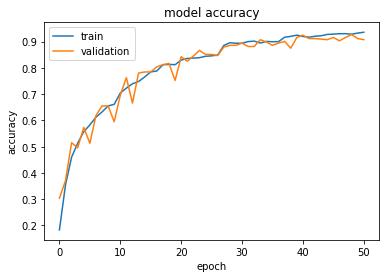

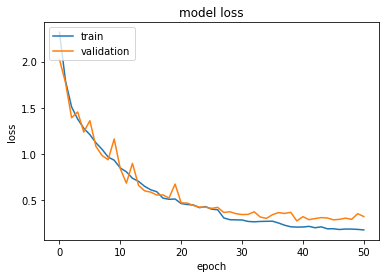

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_gen.classes, y_pred))

C:\Users\farhe\AppData\Local\Temp\ipykernel_4708\3071142573.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)


Confusion Matrix
[[16  0  0  0  1  0  9  0  0  0  0  0]
 [ 0 35  3  0  0  0  0  0  0  0  1  0]
 [ 0  0 25  1  1  0  0  0  0  0  1  0]
 [ 0  0  0 56  0  0  0  0  2  3  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  0  0  1]
 [ 4  0  0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 21  0  0  0  0]
 [ 0  0  0  1  1  0  0  0 49  0  0  0]
 [ 0  0  0  0  0  0  0  0  2 21  0  0]
 [ 0  0  0  0  0  1  0  0  0  1 47  0]
 [ 0  1  0  0  1  0  1  0  0  0  0 35]]


In [16]:
print('Classification Report')
print(classification_report(validation_gen.classes, y_pred, target_names=CATEGORIES))

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.80      0.62      0.70        26
                 Charlock       0.97      0.90      0.93        39
                 Cleavers       0.89      0.89      0.89        28
         Common Chickweed       0.97      0.92      0.94        61
             Common wheat       0.85      1.00      0.92        22
                  Fat Hen       0.96      0.98      0.97        47
         Loose Silky-bent       0.86      0.94      0.90        65
                    Maize       1.00      0.95      0.98        22
        Scentless Mayweed       0.92      0.96      0.94        51
          Shepherds Purse       0.84      0.91      0.87        23
Small-flowered Cranesbill       0.96      0.96      0.96        49
               Sugar beet       0.97      0.92      0.95        38

                 accuracy                           0.92       471
                macro avg       0.92  